### Modeling

In [40]:
# Import all the tools we need

# Regular EDA (Exploratory data analysis) and ploting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# We want our plots to apear inside the notebook|
%matplotlib inline


# Models from Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [41]:
from xgboost import XGBClassifier

In [42]:

df = pd.read_csv("../../data/data.csv")
print("=x"*40)
print("\n\n\n")
print(f"Soil Liquifaction Data :\n\t\t{df.shape[0]} Number of Rows \n\t\t&\n\t\t{df.shape[1]} Number of Columns")
print("\n\n\n")
print("=x"*40)
# df.shape -> (rows, columns)

=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x




Soil Liquifaction Data :
		210 Number of Rows 
		&
		20 Number of Columns




=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x=x


In [43]:
# Split data into X and y
X = df.drop("outcome",axis=1)

y = df["outcome"]

In [44]:
# Split data into train and test sets
np.random.seed(42)

# Split into train and test set
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2)

Now We've got our data into training and test sets, its time to train and test the model<br>
We'll train it (findthe patterns) on the training set.<br>
And we'll test it (use the patterns) on the test set.<br>

We're going to try 3 different machine learning models-
> 1. Logistic Regression
> 2. K-Nearest Neighbour Classifier
> 3. Random Forest Classifier

In [45]:
# Scaling the data

from sklearn.preprocessing import StandardScaler

scalar = StandardScaler().fit(X_train)

X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [46]:
# Puts model into a dictionary

models = {"Logistic Regression": LogisticRegression(),
          "KNN":KNeighborsClassifier(),
          "XGB":XGBClassifier(),
          "Random Forest":RandomForestClassifier()}

# Create a function to fit and score models

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    Models : a dict of different Sklearn ml models
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train : training labels
    y_test : testing labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    for name, model in models.items():
        # Fit the model to data
        model.fit(X_train,y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test,y_test)
    return model_scores

In [47]:
df.dropna(inplace=True)


In [48]:
from sklearn.impute import SimpleImputer

y_imputer = SimpleImputer(strategy='mean')
y_train_imputed = y_imputer.fit_transform(y_train.values.reshape(-1, 1))
y_test_imputed = y_imputer.transform(y_test.values.reshape(-1, 1))


In [49]:
# Assuming your target variable is named 'outcome'
# Convert it into binary labels based on a threshold (e.g., 0.5)
y_train_binary = (y_train > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)


In [50]:
from sklearn.impute import SimpleImputer

# Impute missing values in features X_train and X_test with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now, you can proceed with encoding the target variable 'outcome' using LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Encode categorical labels into numerical values for the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [51]:
model_scores = fit_and_score(models,
                             X_train_imputed,
                             X_test_imputed,
                             y_train_encoded,
                             y_test_encoded)
model_scores


{'Logistic Regression': 0.8095238095238095,
 'KNN': 0.7380952380952381,
 'XGB': 0.8809523809523809,
 'Random Forest': 0.8571428571428571}

### Model Comparison

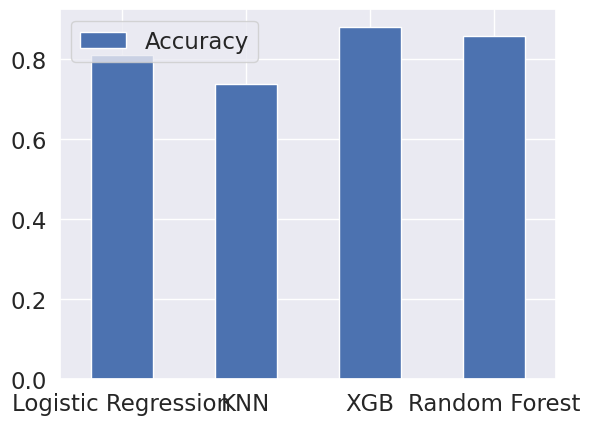

In [52]:
model_compare = pd.DataFrame(model_scores,
                             index=["Accuracy"])
model_compare.T.plot.bar()
plt.xticks(rotation=0);

Now we've got a baseline model.. and we know a model's first prediction aren't always what we should based our next setp off. what should we do?

Let's look at the following:
* HyperParameter tuning
* Feature importance
* Confusion matrix
* Cross-validation
* Precision
* F1 score

## Hyperparameter Tuning

### 1. KNN

In [72]:
# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1,21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop thorugh different n_neighbors

for i in neighbors:
    knn.set_params(n_neighbors=i)

    # Fit the algorithm
    knn.fit(X_train_imputed, y_train_encoded)

    # Update the training scores list
    train_scores.append(knn.score(X_train_imputed, y_train_encoded))

    # Update the testing scores list
    test_scores.append(knn.score(X_test_imputed,y_test_encoded))


Maximum KNN score on the test data: 92.86%


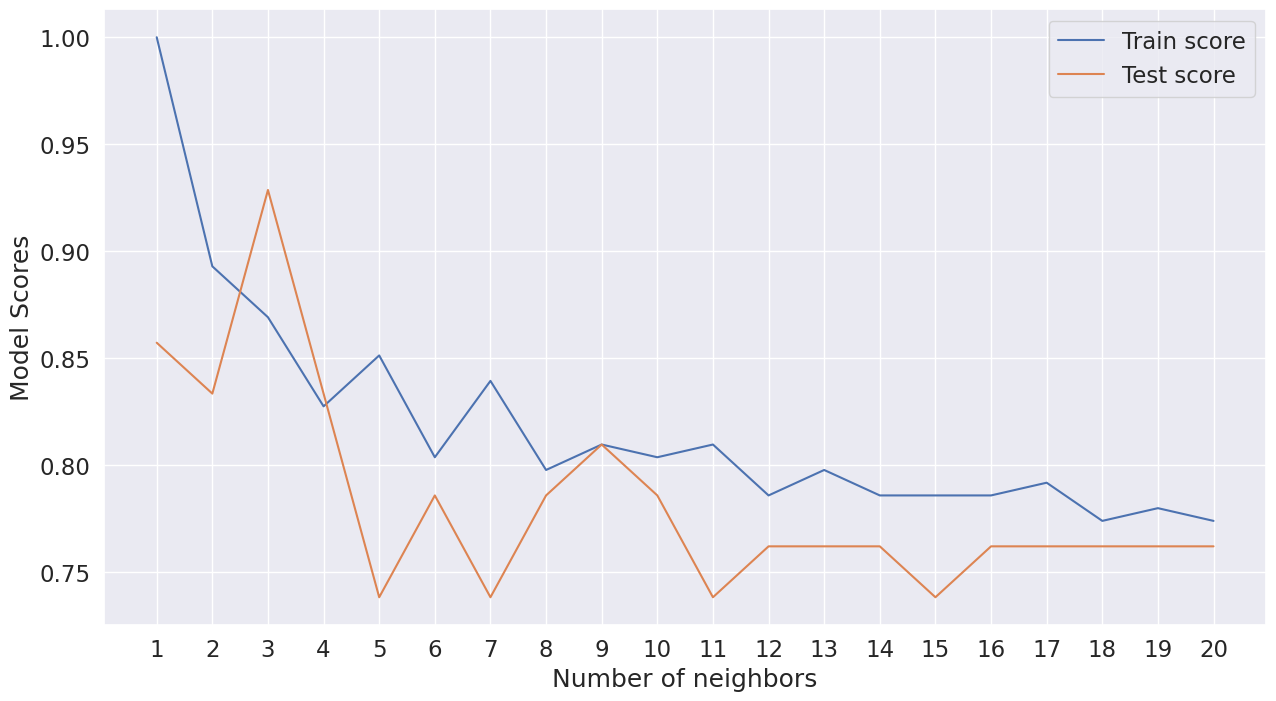

In [73]:
plt.figure(figsize=(15, 8))
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label = "Test score")
plt.xticks(np.arange(1,21,1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model Scores")
plt.legend()


print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%");

## Hyperparameter tuning with Randomized SearchCV

We're going to tune:

2. LogisticRegression()
3. RandomForestCLassfier()

...Using RandomizedSearchCV

In [74]:
# Create a hyperparameter grid for LogisticRegression

log_reg_grid = {"C":np.logspace(-4,4,30),
                "solver":["liblinear"]}

# Create hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators" : np.arange(10,100,50),
          "max_depth":[None,3,5,10],
          "min_samples_split": np.arange(2,20,2),
          "min_samples_leaf":np.arange(1,20,2)}

Now We've got the hyperparameters grids setup for each of our models, let's tune them using RandomizedSearchCV...

In [75]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for logisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions=log_reg_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True)

# Fit Random hyperparameter search model for logisticRegression
rs_log_reg.fit(X_train_imputed, y_train_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [76]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.1082636733874054}

In [77]:
rs_log_reg.score(X_test_imputed,y_test_encoded)

0.8095238095238095

Now as we've tuned logisticRegression(), Lets do same with RandomForestClassfiers()

In [78]:
# Setup Random seed
np.random.seed(42)

# Setup random hyperparameters search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=100,
                           verbose=True)

# Fit the random Hyperprameter search mode for randomforestclassifier()
rs_rf.fit(X_train_imputed, y_train_encoded)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 60])},
                   verbose=True)

In [79]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': 10,
 'min_samples_split': 16,
 'min_samples_leaf': 7,
 'max_depth': 3}

In [80]:
# Evaluate the randomized search RandomForestClassifier model
rs_rf.score(X_test_imputed,y_test_encoded)

0.7380952380952381

## Evaluating our tuned machine learning classifier, beyond accuracy.

* Confusion Matrix
* Classification report
* Precision
* Recall
* F1-Score

...and it would be great if cross-validation was used where possible.

To make comparisons and evaluate our trained model, first we need to make predictions.

In [81]:
print(classification_report(y_test_encoded,y_preds))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        33
           1       0.78      0.78      0.78         9

    accuracy                           0.90        42
   macro avg       0.86      0.86      0.86        42
weighted avg       0.90      0.90      0.90        42



### Calculate evaluation metrics using CrossValidation

Modelling our best model with its best parameter

In [82]:
rs_rf.score(X_test_imputed,y_test_encoded)

0.7380952380952381

### Feature Importance

Feature Importance is another as asking, "which feature contributed" most to the outcomes of the model and how did they contributed<br>
Finding Feature imp. is different for each machine learning model<br>
Let's Find the feature importance for our LogisticRegression Model (Because knn do not have feature importance and it is our second best performing model)<br>

In [83]:
# Fit an instance of LogisticRegression

clf = LogisticRegression(C = 0.20433597178569418,
                         solver = 'liblinear')
clf.fit(X_test_imputed,y_test_encoded);

In [84]:
# Check Coef_
clf.coef_

array([[ 0.14483615, -0.37938359, -0.10638168, -0.13343456, -0.00170611,
        -0.03080765,  0.17639235, -0.20932015, -0.20481864, -0.05847399,
        -0.10684382,  0.03577398,  0.31613222, -0.03489958,  0.03918373,
         0.02772495, -0.09263083,  0.01174807, -0.12321845]])

In [85]:
# Match coef's of features to coloumns

feature_dict = dict(zip(df.columns,list(clf.coef_[0])))
feature_dict

{'mag': 0.14483615087948234,
 's0': -0.37938358867023414,
 'sp0': -0.10638168201058054,
 'spt': -0.13343455894455525,
 'ag': -0.001706114763278842,
 'tau_dinamic': -0.030807647137972523,
 'pfine': 0.1763923457882748,
 'uwgwt': -0.2093201529350563,
 'uwbgwt': -0.20481863677790027,
 'ccb': -0.058473991245421846,
 'smmc': -0.10684381513254422,
 'msf': 0.03577397599458402,
 'nonvalues': 0.3161322166646259,
 'ocf ': -0.03489958133888017,
 'swvu': 0.03918373461083088,
 'cos': 0.02772494889654679,
 'cmde': -0.0926308250441561,
 'csrmd': 0.011748070686417993,
 'n1cs': -0.12321845165220653}

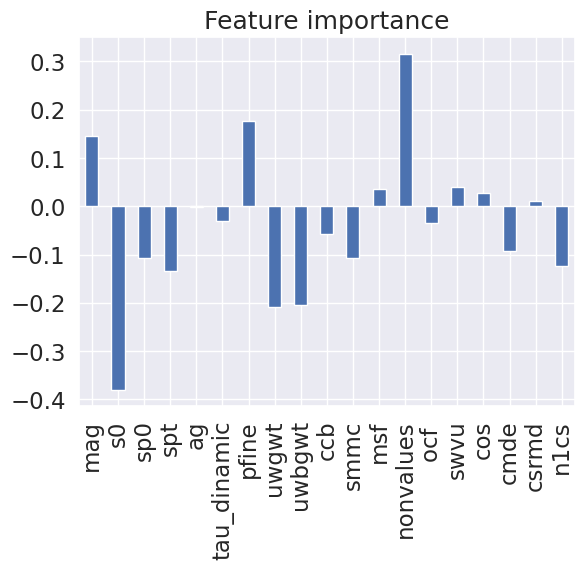

In [86]:
# Visualize Feature Importance
feature_df = pd.DataFrame(feature_dict,index=[0])
feature_df.T.plot.bar(title="Feature importance",legend=False);

In [87]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup Random seed
np.random.seed(42)

# Setup random hyperparameters search for XGBoostClassifier
xgb_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4]
}

rs_xgb = RandomizedSearchCV(XGBClassifier(),
                            param_distributions=xgb_grid,
                            cv=5,
                            n_iter=100,
                            verbose=True)

# Fit the random Hyperparameter search mode for XGBoostClassifier
#rs_xgb.fit(X_test_imputed,y_test_encoded)

rs_xgb.fit(X_train_imputed, y_train_encoded)

# Find the best hyperparameters
rs_xgb.best_params_

# Evaluate the randomized search XGBoostClassifier model
rs_xgb.score(X_test_imputed,y_test_encoded)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


0.9047619047619048

In [88]:
y_preds = rs_xgb.predict(X_test_imputed)

In [89]:
best_xgb_model_filename = '../../model/best_xgb_model.json'
rs_xgb.best_estimator_.save_model(best_xgb_model_filename)